In [1]:
#cells_meta_f = ""
# Input info
# params
p_thresh = 0.1 


#indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor1/mt_as_clones_dendro/af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0"
#outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_mt_bestparams_af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0/clonalShift_method_mt_as_clones_dendro/clones_ranked"
#cloneID = ""
clone_id = "cloneID" # "den_clust"
#clust_id = "clusterID"


indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor0/mt_as_clones_dendro/af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_init_mt_bestparams_af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0/clonalShift_method_mt_as_clones_dendro/clones_ranked"



In [16]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%load_ext autoreload
%autoreload 2
from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

from mplh import cluster_help as ch

from scipy.stats import rankdata, gmean


fig_utils from mplh


In [3]:
#cells_meta = pd.read_csv(cells_meta_f, sep="\t")

In [4]:
indir

'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor0/mt_as_clones_dendro/af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0'

## Load ncells and save to output. Sort by ncells

In [5]:
noInput_ncells = pd.read_csv(join(indir, "noInput_ncells.csv"),  index_col=0)
input_ncells = pd.read_csv(join(indir, "input_ncells.csv"), index_col=0)

# input_ncells_df = input_ncells.reset_index().melt(id_vars="index", value_name="pval")
# noInput_ncells_df = noInput_ncells.reset_index().melt(id_vars="index", value_name="pval")

# noInput_ncells_df["condition"] = "cultured"
# noInput_shuffle_df["condition"] = "cultured"
# input_ncells_df["condition"] = "input"
# input_shuffle_df["condition"] = "input"

input_ncells = input_ncells.groupby(clone_id).sum()[["count"]].sort_values(by="count")[::-1]
noInput_ncells = noInput_ncells.groupby(clone_id).sum()[["count"]].sort_values(by="count")[::-1]
ncells_df = pd.merge(input_ncells,noInput_ncells,left_index=True, right_index=True, suffixes=["_input", "_cultured"])
ncells_df = ncells_df.loc[ncells_df.sum(axis=1).sort_values()[::-1].index]
ncells_df

,count_input,count_cultured
cloneID,,
0_C5,1515,1063
0_C8,1403,964
0_C0,71,2009
0_C7,98,189
0_C4,65,216
0_C2,37,218
0_C3,55,179
0_C1,68,147
0_C6,21,146


## Load shuffle hypergeometric results for input and cultured
## Convert into long df with cloneID ('index'), clusterID ('variable'), pval, method (hypergeo or one of four shuffle methods), and condition ('input' or 'cultured')

In [6]:
noInput_hyper = pd.read_csv(join(indir, "noInput_hypergeo_pvals.csv"),  index_col=0)
noInput_shuffle_df = pd.read_csv(join(indir, "noInput_shuffle_results_pvals.csv"), index_col=0)
noInput_shuffle_df = noInput_shuffle_df.rename({"value":"pval"}, axis=1)

input_hyper = pd.read_csv(join(indir, "input_hypergeo_pvals.csv"), index_col=0)
input_shuffle_df = pd.read_csv(join(indir, "input_shuffle_results_pvals.csv"), index_col=0)

input_shuffle_df = input_shuffle_df.rename({"value":"pval"}, axis=1)
input_shuffle_df

input_hyper_df = input_hyper.reset_index().melt(id_vars="index", value_name="pval")
input_hyper_df["method"] = "hypergeo"
noInput_hyper_df = noInput_hyper.reset_index().melt(id_vars="index", value_name="pval")
noInput_hyper_df["method"] = "hypergeo"



noInput_hyper_df["condition"] = "cultured"
noInput_shuffle_df["condition"] = "cultured"
input_hyper_df["condition"] = "input"
input_shuffle_df["condition"] = "input"


In [7]:
input_df = pd.concat((input_hyper_df, input_shuffle_df), axis=0, ignore_index=True)
input_df

noInput_df = pd.concat((noInput_hyper_df, noInput_shuffle_df), axis=0, ignore_index=True)
noInput_df

df = pd.concat((input_df, noInput_df), axis=0).reset_index(drop=True)
#df = pd.merge(input_df, noInput_df, on=["index", "variable", "method"], suffixes=["_input", "_cultured"])
df

,index,variable,pval,method,condition
0,0_C0,CLP,0.392186,hypergeo,input
1,0_C1,CLP,0.571025,hypergeo,input
2,0_C2,CLP,0.361902,hypergeo,input
3,0_C3,CLP,0.718161,hypergeo,input
4,0_C4,CLP,0.458743,hypergeo,input
...,...,...,...,...,...
1295,0_C5,neutrophil B,1.000000,clone_min,cultured
1296,0_C6,neutrophil B,0.200000,clone_min,cultured
1297,0_C7,neutrophil B,1.000000,clone_min,cultured
1298,0_C8,neutrophil B,0.184000,clone_min,cultured


## Create 'sig score' that merges the hypergeo and the shuffle results. Score 0-4, with 4 the highest

In [8]:
p_df = df.copy()
p_df["is_sig"] = p_df["pval"]<p_thresh
p_df

def check_sig(x):
    #print(x.head())
    name, clust, cond = x.name
    x = x.set_index("method")["is_sig"]
    assert(x.index.duplicated().sum()==0)
    #print('x',x )
#     sig = x["hypergeo"] 
#     #print('sig', sig)
#     sig = sig.astype(int) + (x["global_all"]).astype(int)
#     sig = sig.astype(int) + (x["clone_min"]).astype(int)
#     sig = sig.astype(int) + (x["global_min"]).astype(int)
    

    
#     sig[(x["hypergeo"]==True)] = 1
#     sig[(x["hypergeo"]==True) & (x["global_all"]==True) ] = 2
#     sig[(x["hypergeo"]==True) & (x["global_all"]==True)
#                       & (x["clone_min"]==True)] = 3
    #print('x',x)
    sig = 0    
    if x["hypergeo"]==True:
        if x["global_all"]==True:
            if (x["clone_min"]==True):
                if (x["global_min"]==True):
                    sig = 4    
                else:
                    sig = 3
            else:
                sig = 2
        else:
            sig = 1
    return sig

p_df = p_df.groupby(["index","variable", "condition"]).apply(check_sig)
p_df


# df.loc[(df["method"] == "hypergeo") & (df["condition"] == "input")].pivot(index="index", columns="variable", values="pval")

# df.loc[(df["method"] == "hypergeo") & (df["condition"] == "cultured")].pivot(index="index", columns="variable", values="pval")

p_df_out = p_df.reset_index().rename({0:"significant_score"}, axis=1)
#p_df_out.set_index( )
p_df_out["cluster_condition"] = p_df_out.apply(lambda x: f'{x["variable"]}_{x["condition"]}', axis=1)


#p_df_out["clone_condition"] = p_df_out.apply(lambda x: f'{x["index"]}_{x["condition"]}', axis=1)

p_df_out = p_df_out.pivot(index='index', columns='cluster_condition', values="significant_score").fillna(0)

p_df_out

cluster_condition,CLP_cultured,CLP_input,DC_input,MEP_input,MPP/CMP/GMP B_cultured,MPP/CMP/GMP B_input,MPP/CMP/GMP C_cultured,MPP/CMP/GMP C_input,MPP/CMP/GMP D_cultured,MPP/CMP/GMP D_input,...,macrophage_cultured,macrophage_input,meg/erythroid_cultured,meg/erythroid_input,monocyte_cultured,monocyte_input,neutrophil B_cultured,neutrophil B_input,neutrophil_cultured,neutrophil_input
index,,,,,,,,,,,,,,,,,,,,,
0_C0,0,0,0,0,0,0,0,0,4,0,...,2,0,0,0,2,0,0,0,0,0
0_C1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0_C2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0_C3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0_C4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0_C5,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,2,0
0_C6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0_C7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0_C8,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


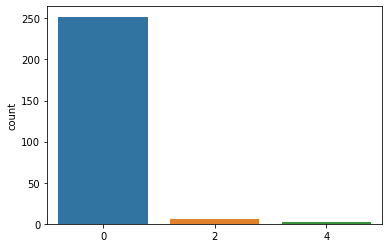

In [9]:
sns.countplot(p_df)
plt.savefig(join(outdir, "hypergeo_sig_score_distribution.pdf"))


## Save heatmap for initial hypergeo 

In [10]:
clone_meta = pd.DataFrame(index=p_df_out.columns, columns = ["condition"])
clone_meta["condition"] = ["input" if "input" in x else "cultured" for x in clone_meta.index]
clone_meta

,condition
cluster_condition,
CLP_cultured,cultured
CLP_input,input
DC_input,input
MEP_input,input
MPP/CMP/GMP B_cultured,cultured
MPP/CMP/GMP B_input,input
MPP/CMP/GMP C_cultured,cultured
MPP/CMP/GMP C_input,input
MPP/CMP/GMP D_cultured,cultured


## Input and culture in same heatmap- show clones that were significant in i'th Input cluster label and j'th culture cluster label

merge_df name 0_C0 0_C1 0_C2 0_C3 0_C4 0_C5 0_C6 0_C7 0_C8 0_C9
name                                                  
0_C0                                                  
0_C1                                                  
0_C2                                                  
0_C3                                                  
0_C4                                                  
0_C5                                                  
0_C6                                                  
0_C7                                                  
0_C8                                                  
0_C9                                                  
count name  0_C0  0_C1  0_C2  0_C3  0_C4  0_C5  0_C6  0_C7  0_C8  0_C9
name                                                            
0_C0     0     0     0     0     0     0     0     0     0     0
0_C1     0     0     0     0     0     0     0     0     0     0
0_C2     0     0     0     0     0     0     0     0     0     0


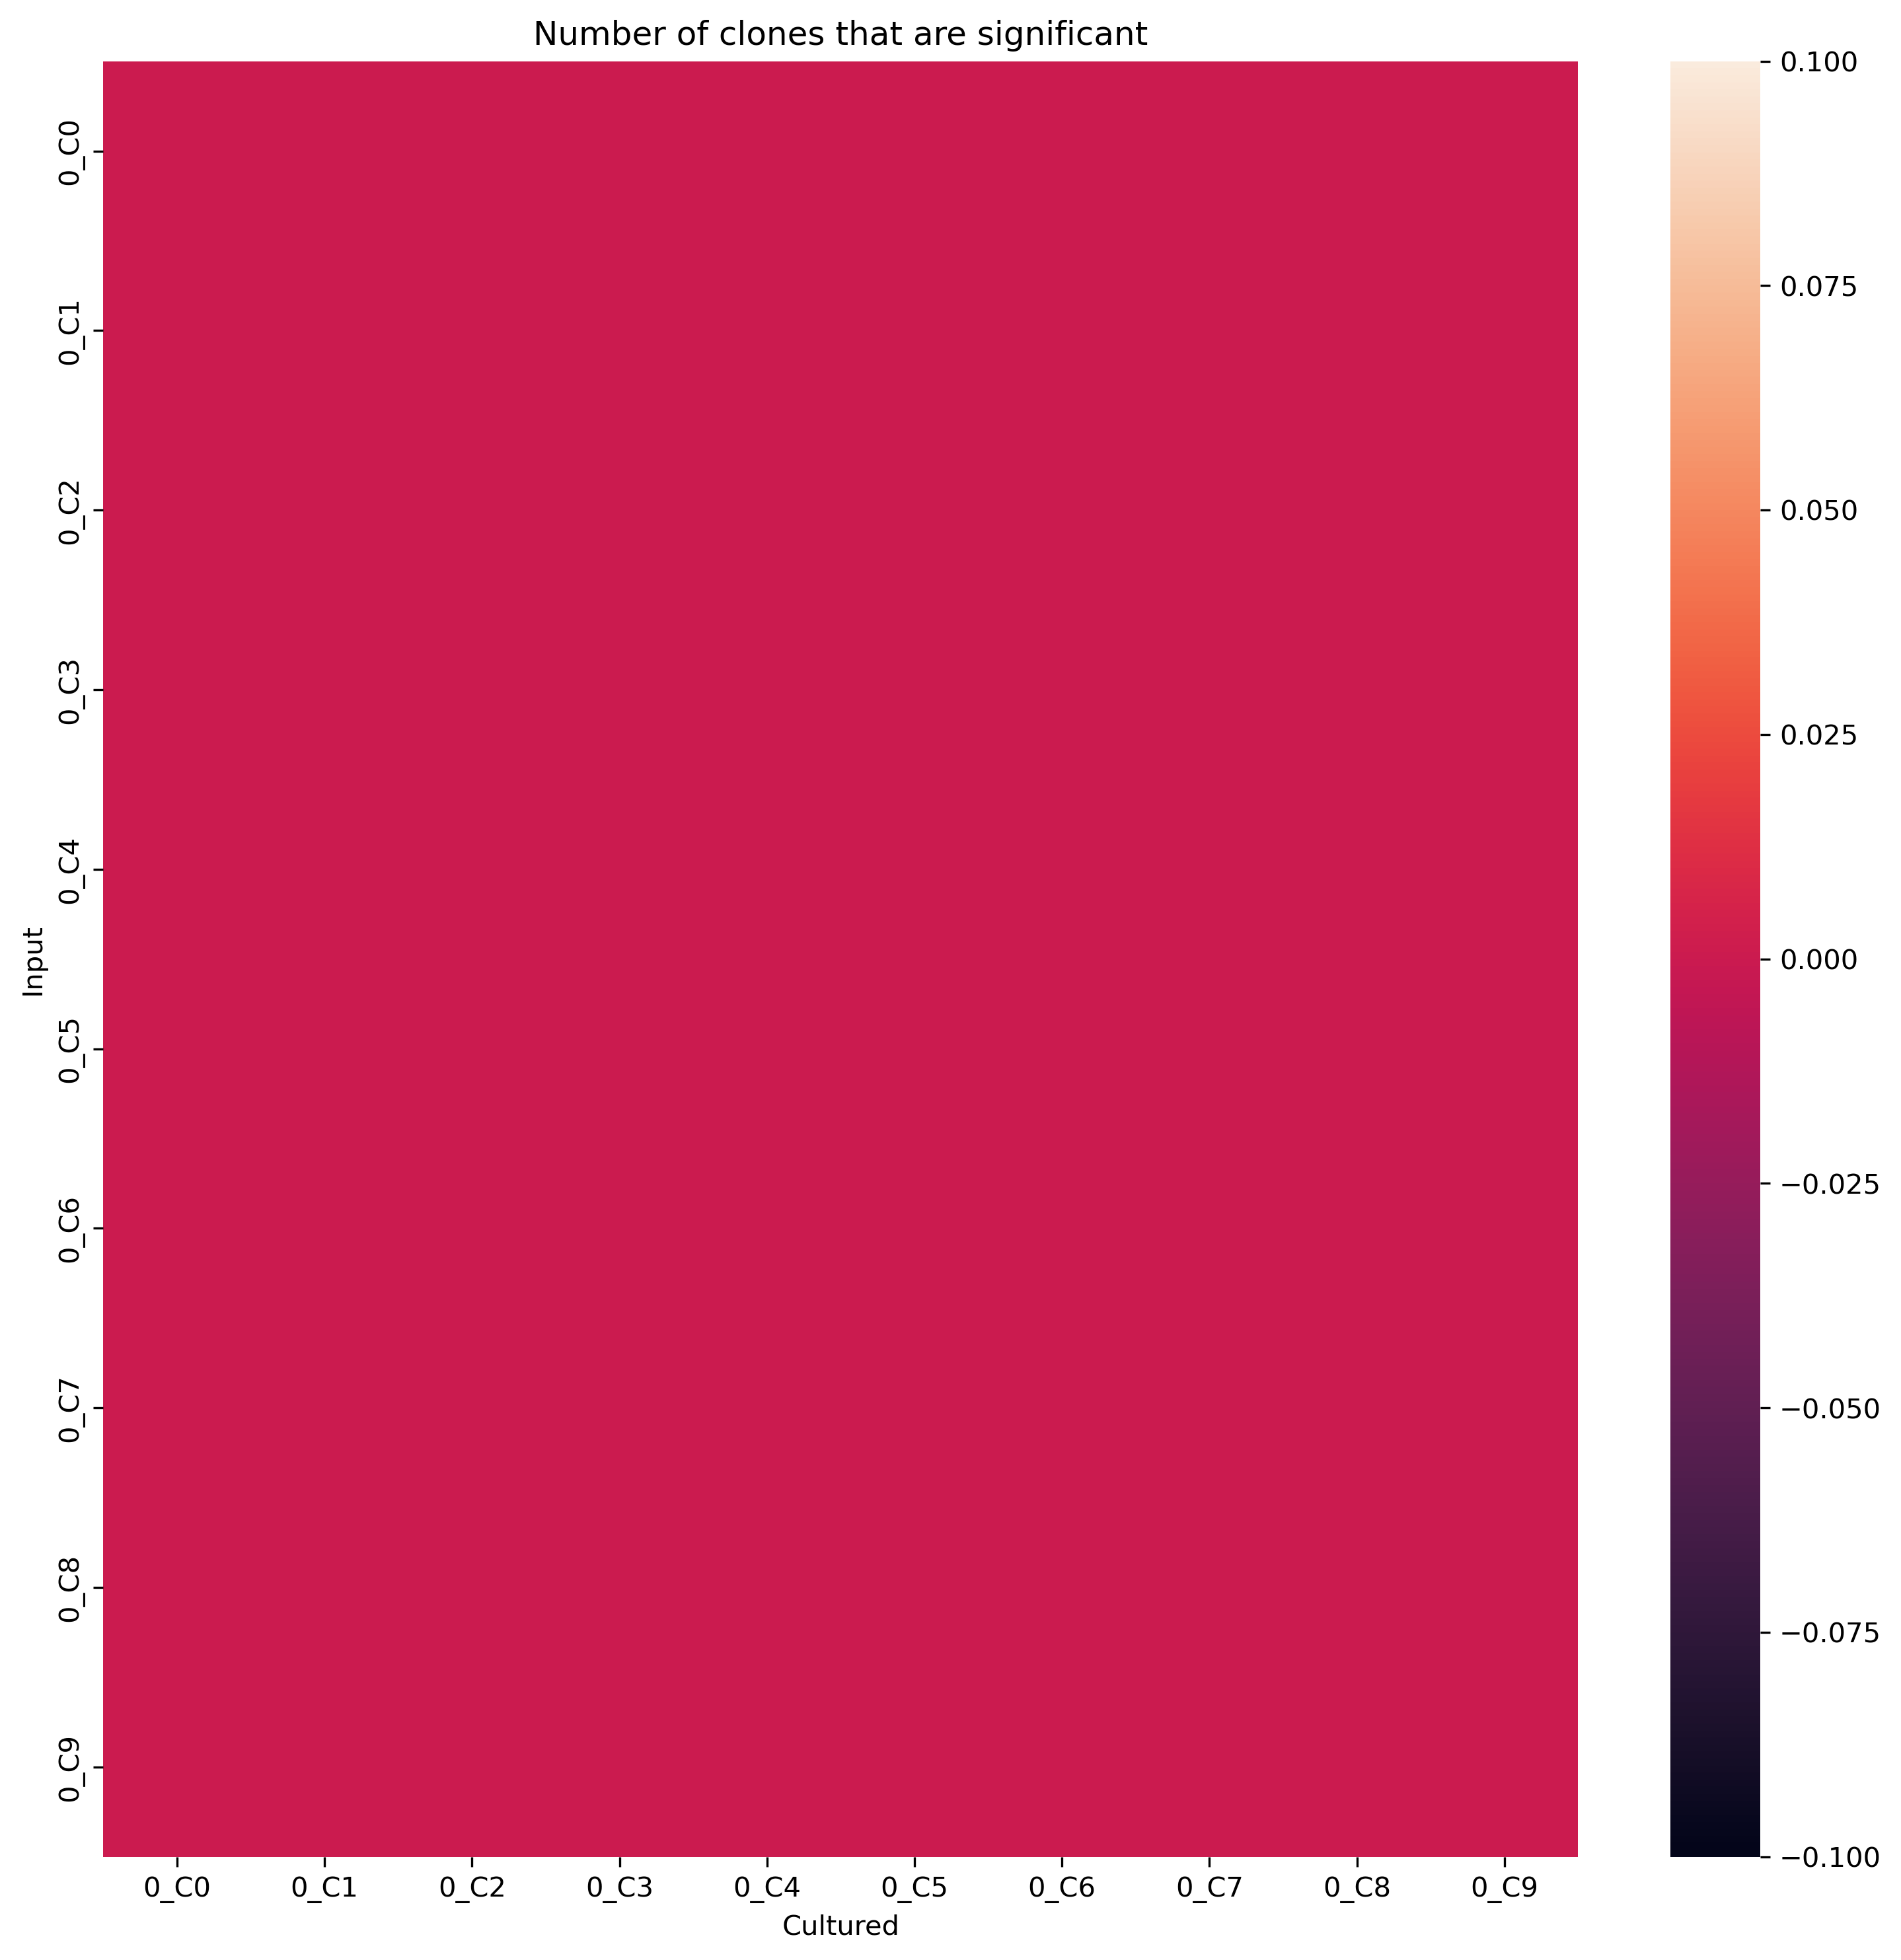

In [40]:
a_input = df.loc[(df["method"] == "hypergeo") & (df["condition"] == "input")].pivot(index="index", columns="variable", values="pval")
b_cultured = df.loc[(df["method"] == "hypergeo") & (df["condition"] == "cultured")].pivot(index="index", columns="variable", values="pval")
merged_df, merged_count_df = cs.merge_hypergeom(a_input, b_cultured, 
                                             "Input", "Cultured", p_thresh=p_thresh,
                                             f_save=join(outdir,f"culture_input_clone_lineages"))


In [17]:
# a_input = df.loc[(df["method"] == "hypergeo") & (df["condition"] == "input")].pivot(index="index", columns="variable", values="pval")
# b_cultured = df.loc[(df["method"] == "hypergeo") & (df["condition"] == "cultured")].pivot(index="index", columns="variable", values="pval")

a_sig = p_df_out[clone_meta[clone_meta["condition"]=="input"].index]
b_sig = p_df_out[clone_meta[clone_meta["condition"]=="cultured"].index]
a_sig.columns = [x.replace("_cultured","").replace("_input","") for x in a_sig.columns]
b_sig.columns = [x.replace("_cultured","").replace("_input","") for x in b_sig.columns]
b_sig

,CLP,MPP/CMP/GMP B,MPP/CMP/GMP C,MPP/CMP/GMP D,MPP/CMP/GMP,eosonophil,erythroid,macrophage,meg/erythroid,monocyte,neutrophil B,neutrophil
index,,,,,,,,,,,,
0_C0,0,0,0,4,0,2,0,2,0,2,0,0
0_C1,0,0,0,0,0,0,0,0,0,0,0,0
0_C2,0,0,0,0,0,0,0,0,0,0,0,0
0_C3,0,0,0,0,0,0,0,0,0,0,0,0
0_C4,0,0,0,0,0,0,0,0,0,0,0,0
0_C5,0,0,2,0,0,0,0,0,0,0,0,2
0_C6,0,0,0,0,0,0,0,0,0,0,0,0
0_C7,0,0,0,0,0,0,0,0,0,0,0,0
0_C8,0,4,0,0,0,0,0,0,0,0,2,0


merge_df Empty DataFrame
Columns: [MPP/CMP/GMP B, MPP/CMP/GMP D]
Index: []
count Empty DataFrame
Columns: [MPP/CMP/GMP B, MPP/CMP/GMP D]
Index: []


ValueError: zero-size array to reduction operation fmin which has no identity

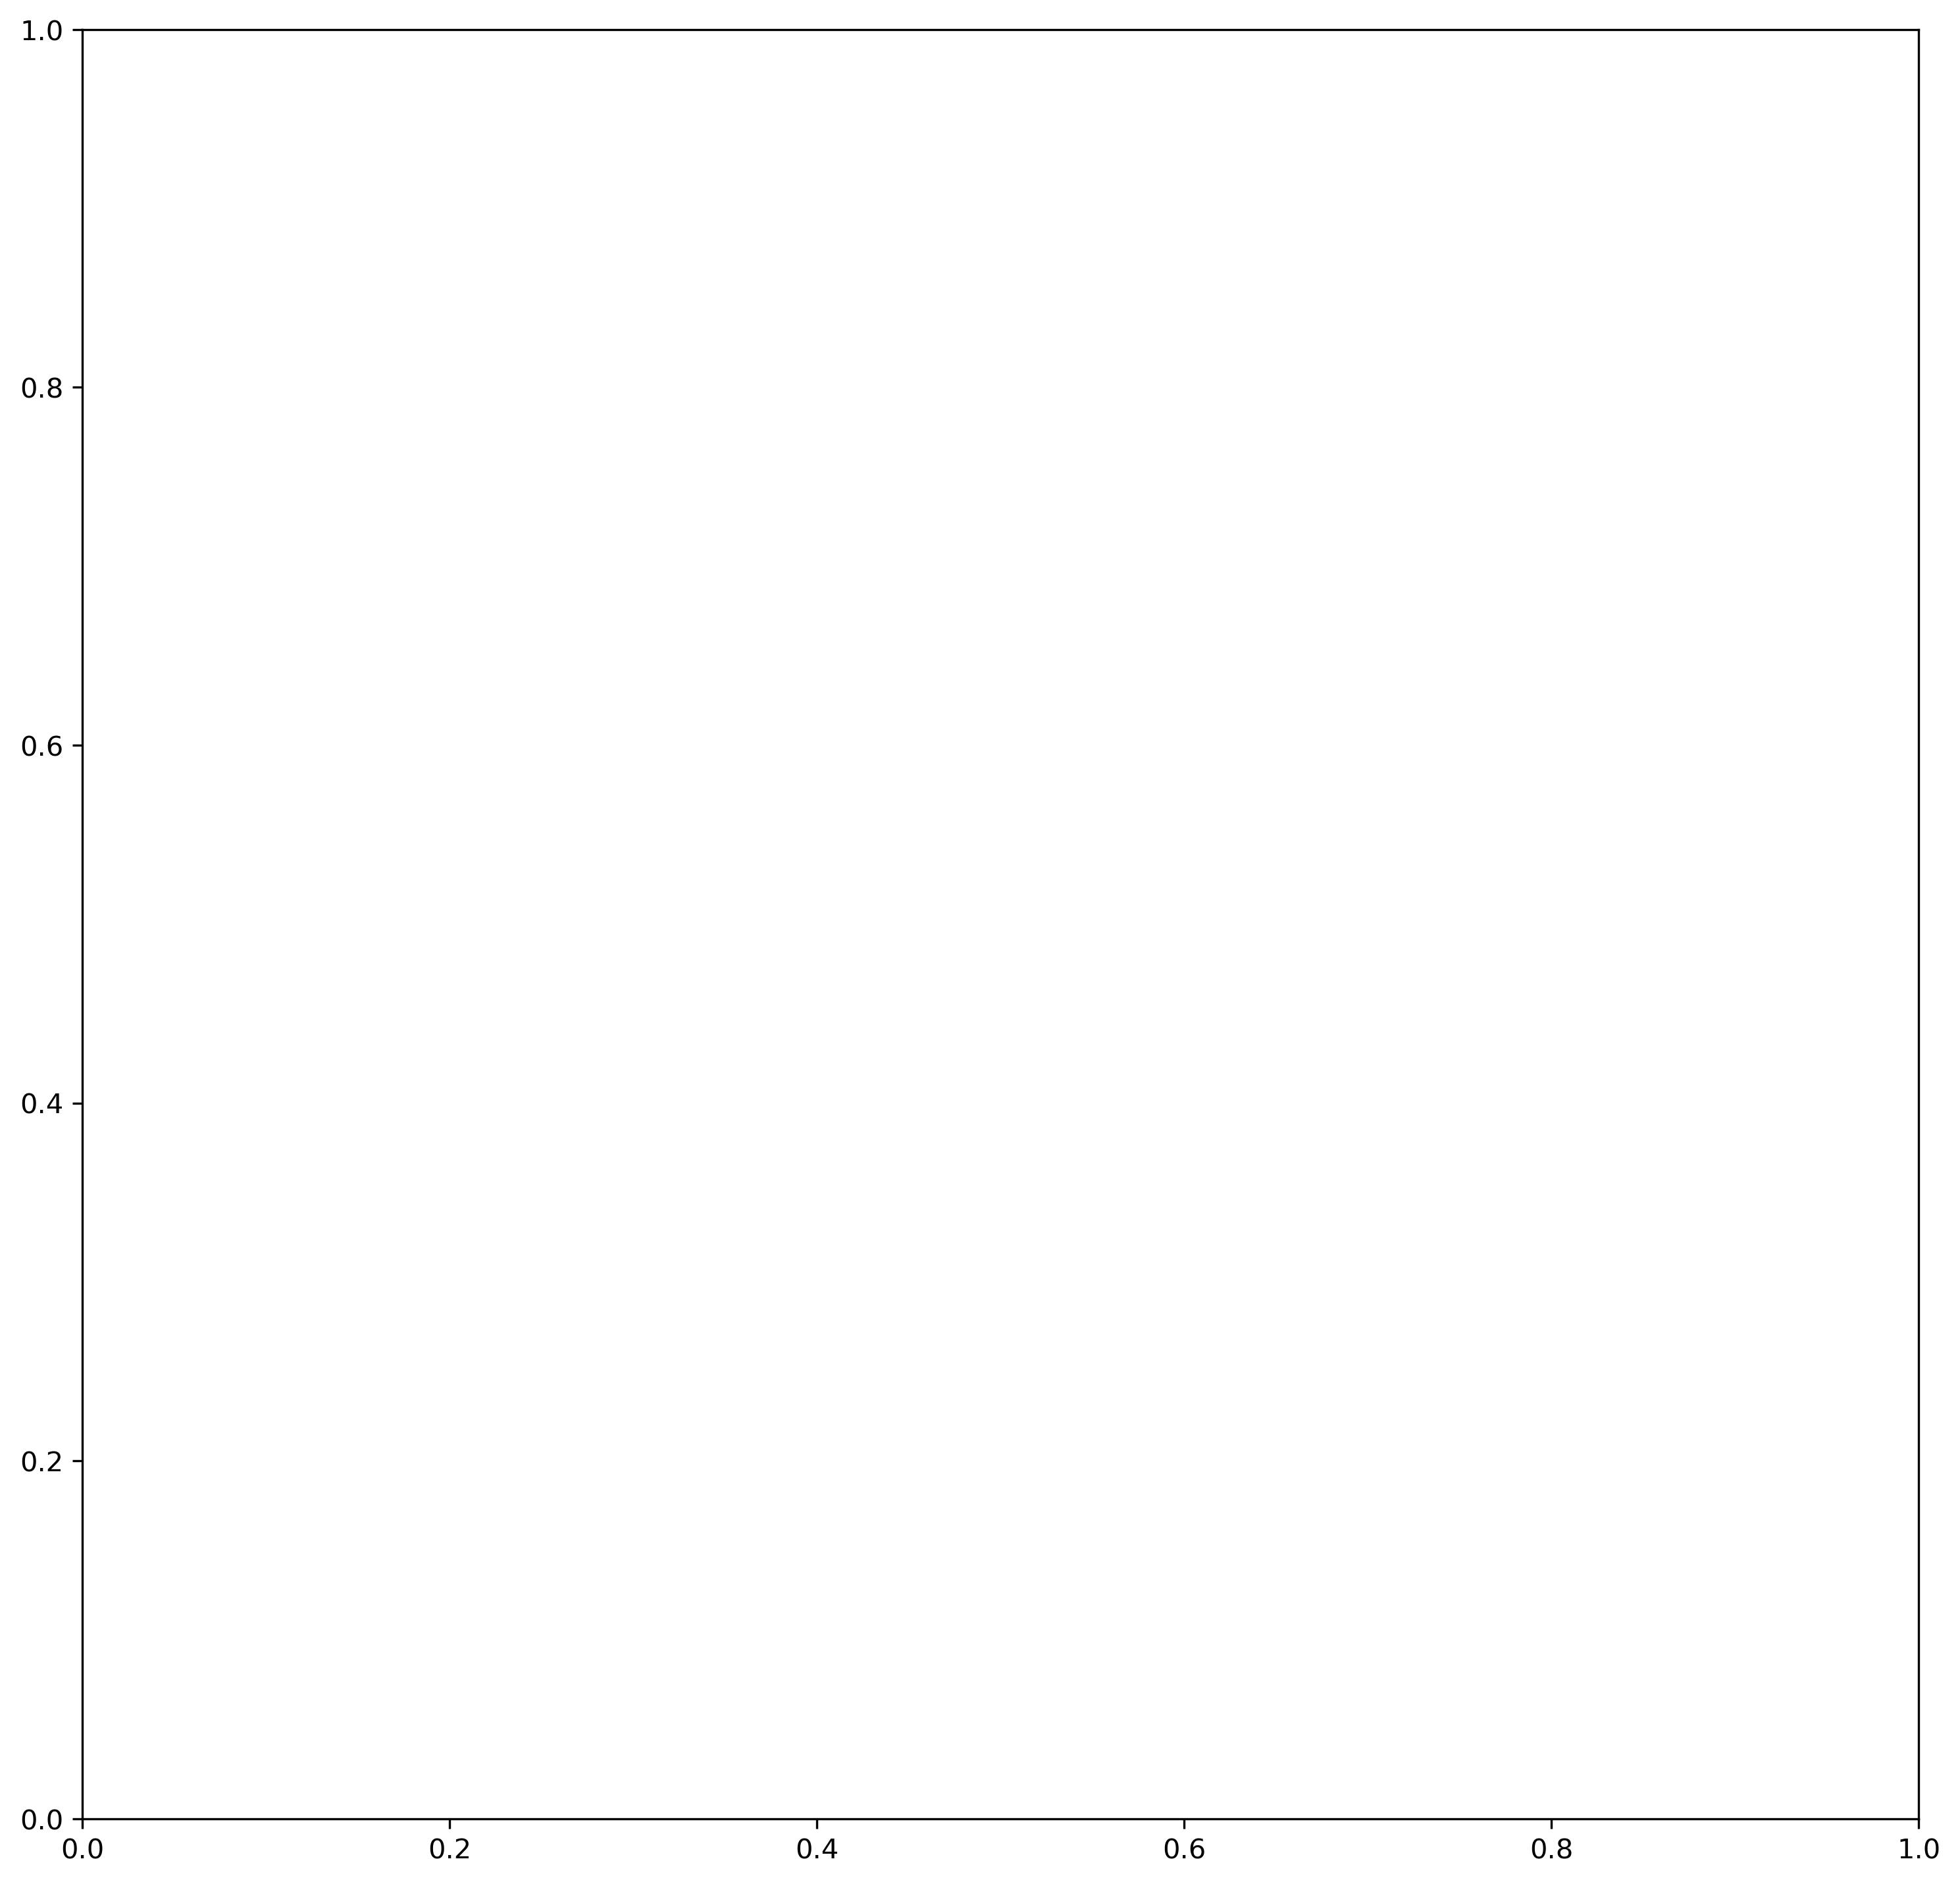

In [19]:
merged_df, merged_count_df = cs.merge_hypergeom(1/(1+a_sig), 1/(1+b_sig), 
                                               "Input", "Cultured", p_thresh=0.25,
                                                title="Clones sig in a cluster in both the input and culture (score=4/4)",
                                                f_save=join(outdir,f"sig_score4_culture_input_clone_lineages"))


merged_df, merged_count_df = cs.merge_hypergeom(1/(1+a_sig), 1/(1+b_sig), 
                                                "Input", "Cultured", p_thresh=0.33,
                                                title="Clones sig in a cluster in both the input and culture (score=3/4)",
                                                f_save=join(outdir,f"sig_score3_culture_input_clone_lineages"))


merged_df, merged_count_df = cs.merge_hypergeom(1/(1+a_sig), 1/(1+b_sig), 
                                             "Input", "Cultured", p_thresh=0.5,
                                             title="Clones sig in a cluster in both the input and culture (score=2/4)",
                                             f_save=join(outdir,f"sig_score2_culture_input_clone_lineages"))


merged_df, merged_count_df = cs.merge_hypergeom(1/(1+a_sig), 1/(1+b_sig), 
                                             "Input", "Cultured", p_thresh=1,
                                             title="Clones sig in a cluster in both the input and culture (score=1/4)",
                                             f_save=join(outdir,f"sig_score1_culture_input_clone_lineages"))


In [ ]:
## Plot sig score for Input hypergeo and plot cultured on same clone-axis.

# g = sns.clustermap(p_df_out[clone_meta[clone_meta["condition"]=="input"].index])

# inds = g.dendrogram_row.dendrogram["leaves"]
# plt.savefig(join(outdir, "input_sigScore.pdf"))
# #cols = g.dendrogram_col.dendrogram["leaves"]
# #row_meta = row_meta.iloc[inds]

# sns.clustermap(p_df_out[clone_meta[clone_meta["condition"]=="cultured"].index].iloc[inds], 
#                row_cluster=False)

# plt.savefig(join(outdir, "cultured_sigScore.pdf"))

## Get the minimum of each clone shift. This will be used for rankigng later

In [ ]:
min_df = df.groupby(["index", "method", "condition"]).min()["pval"].reset_index()
min_df

min_df_wide = min_df.pivot(index="index", values="pval", columns=["method", "condition"])
min_df_wide.columns = ['_'.join(col).strip() for col in min_df_wide.columns.values] # flatten to 1D columns
min_df_wide
ncells_df["ncells"] = ncells_df.sum(axis=1)
min_df_wide = pd.concat((min_df_wide,ncells_df), axis=1)

rank_df = min_df_wide.apply(lambda x: rankdata(x, method='max'), axis=0)


gmean_ser = rank_df.apply(gmean, axis=1)
gmean_ser = gmean_ser.sort_values()



# *Get the clone order based on the ncells 


In [ ]:
rank_df = rank_df.sort_values("ncells")[::-1]
rank_df
## Get the clone order based on the mean of the rankings
clone_order = rank_df.index
min_df_wide = min_df_wide.loc[clone_order]
rank_df = rank_df.loc[clone_order]
rank_df

In [ ]:
min_clone_meta = pd.DataFrame(index=min_df_wide.columns, columns = ["condition"])
min_clone_meta["condition"] = ["input" if "input" in x else "cultured" for x in min_clone_meta.index]
min_clone_meta

## Plot rankings ordered by clone, annd save output

## Save:
a) cloneID_rank.png  
b) cloneID_order.txt - line-delimited text file with cloneID on each line  
c) cloneID_rank.csv  - csv file of the ranking for each category  
d) all_pvals: all p-values for for each clone-method-cluster-condition

In [ ]:
with open(join(outdir, "cloneID_rank_ncells.txt"), 'w') as f:
    f.write('\n'.join(clone_order))

In [ ]:
rank_df.to_csv(join(outdir, "cloneID_rank_ncells_df.csv"))

## Plot the rankings

In [ ]:
g = ch.plot_cluster(rank_df, to_row_clust=False, to_col_clust=False, col_meta=min_clone_meta[["condition"]])
g.fig.suptitle("Ranking of each method across clones (lowest is best). Top is best-ranked clone")
#plt.savefig(join(outdir, "cloneID_rank_sizes.png"))

In [ ]:
g = sns.clustermap(p_df_out[clone_meta[clone_meta["condition"]=="input"].index].loc[clone_order], row_cluster=False)
plt.savefig(join(outdir, "input_sigScore_cloneOrder.pdf"))
#inds = g.dendrogram_row.dendrogram["leaves"]

#cols = g.dendrogram_col.dendrogram["leaves"]
#row_meta = row_meta.iloc[inds]

sns.clustermap(p_df_out[clone_meta[clone_meta["condition"]=="cultured"].index].loc[clone_order], 
               row_cluster=False)

plt.savefig(join(outdir, "cultured_sigScore_cloneOrder.pdf"))

## Convert p-vals into * or shapes (a. hypergeo sig. b. hyper+global all c. hyper+global all + clone min d. hyper+global all + clone min + global min